In [1]:
import pickle
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from cvxpy import *
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr
from sklearn import linear_model
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rc('font',family='Times New Roman')

In [2]:
# Q[n x n] -- features similarities matrix
# b[n] -- feature relevances
# returns argmin ((w,Qw) - (b,w))

def solve_opt_problem(Q, b): 
    n = np.size(b)
    w = Variable(n)
    A = bmat(Q)
    constraints = [sum_entries(w) <= 1, w >= 0]
    obj = Minimize(quad_form(w, A) - np.array(b) @ w)
    prob = Problem(obj, constraints)
    prob.solve()
    result = np.array(w.value) @ np.ones(1)
    return result

In [3]:
# Q = [Sim(i,j)] 
# b = [Rel(i)]

def create_opt_problem(X, y):
    # X, y = np.array
    (m,n) = np.array(X).shape
    Q = np.zeros((n,n))
    b = np.zeros(n)
    for i in range(n):
        for j in range(n):
            Q[i][j] = (pearsonr(X.T[i], X.T[j])[0])
        b[i] = (pearsonr(X.T[i], y)[0])
    return (Q, b)

In [4]:
#create and solve QP problem

def QP(X, Y):
    (Q, b) = create_opt_problem(X, Y)
    w = solve_opt_problem(Q, b)
    return w

In [5]:
# X -- матрица объект-признак
# _w -- вектор весов признаков
# выход -- матрица, составленная из num самых весовых признаков (столбцов X) 

def select_QP(X, _w, num):
    eps = 1e-9
    (m,n) = np.array(X).shape
    A = 0
    
    w = np.copy(_w)
    norm_w = 0

    c = np.copy(w)
    c = -np.sort(-c)
    temp = c[num-1]
    
    for k in range(n):
        if ((w[k] > temp - eps)):
            A = A + 1
            norm_w = norm_w + w[k]
        else:
            w[k] = 0
    w = w / norm_w

    Xa = np.zeros((m,A))
    i = 0
    for k in range(n):
        if (w[k] > eps):
            Xa.T[i] = X.T[k]
            i = i + 1
    return Xa

In [6]:
# квадрат нормы вектора регрессионных остатков, где регрессионная модель строится только по k отобранным признакам
def Sa(k):
    Xa = select_QP(X, w, k)
    Xa_test = select_QP(test_X, w, k)
    rega = linear_model.LinearRegression()
    rega.fit(Xa, Y)
    Ra = (select_QP(test_X, w, k) @ rega.coef_ - test_Y)
    #return np.mean(Ra ** 2)
    return Ra @ Ra
    

In [7]:
# квадрат нормы вектора регрессионных остатков
def S(k):
    reg = linear_model.LinearRegression()
    reg.fit(X, Y)
    R = (test_X @ reg.coef_ - test_Y)
    #return np.mean(R ** 2)
    return R @ R

In [8]:
def SMAPE(k):
    Xa = select_QP(X, w, k)
    Xa_test = select_QP(test_X, w, k)
    rega = linear_model.LinearRegression()
    rega.fit(Xa, Y)
    Ra = (select_QP(test_X, w, k) @ rega.coef_ - test_Y)
    return np.mean(np.abs(np.divide(Ra, (test_Y + select_QP(test_X, w, k) @ rega.coef_) / 2)))

In [9]:
def vifj(_X, j):
    #j in [0..n-1]
    X = np.copy(_X)
    (m, n) = X.shape
    
    Y = np.zeros((m, n-1))
    for k in range(0,j):
        Y.T[k] = X.T[k]
    for k in range(j+1, n):
        Y.T[k - 1] = X.T[k]
    Z = np.zeros(m)
    Z = X.T[j]
    
    temp = linear_model.LinearRegression()
    temp.fit(Y, Z)
    
    R = ((Y @ temp.coef_) - Z)
    Sj = R @ R
    TSS = np.sum((Z - np.mean(Z) * np.ones(m)) ** 2)
    return TSS / Sj

In [10]:
# максимум из VIF столбцов
# > 10 is bad
def vif(X):
    (m,n) = X.shape
    res = vifj(X,0)
    for k in range(n):
        if (vifj(X, k) > res):
            res = vifj(X,k)
    return res        

In [11]:
def R(X):
    e = np.linalg.eigvals(X.T @ X)
    return np.log(np.min(e) / np.max(e))

In [12]:
# возвращает список критериев качества, если отобрано k признаков
def all(k, n, w):
    Xa_test = select_QP(test_X, w, k)

    AIC = n * np.log(Sa(k) / n) + 2 * k
    BIC = n * np.log(Sa(k) / n) + k * np.log(n)
    Cp = Sa(k) / S(k) - n + 2 * k
    r = R(Xa_test)
    v = vif(Xa_test)
    return (AIC,BIC,Cp,r,v,Sa(k), SMAPE(k))

# Загрузка и обработка данных

In [13]:
#загрузка данных
#period -- число признаков

f = open('data/data.txt')
data = np.transpose([float(line) for line in f])
period = 12

a = np.array(range(12)) 
b = np.array(range(8 * 12)) - 8 * 12
mask = np.hstack((a - 365 * 12, a - 31 * 12, b))

# T -- размер обучающей выборки
# n -- размер тестовой выборки
T = 1000
n = 2000
start = 7200

Y = np.array([data[start + period * i] for i in range(T)])
X = np.array([[data[start + period * i + j] for j in mask] for i in range(T)])

test_Y = np.array([data[start + period * (i + T)] for i in range(n)])
test_X = np.array([ [data[start + period * (i + T) + j] for j in mask] for i in range(n)])

In [14]:
# обучение
w = QP(X,Y)
save_w = np.copy(w)

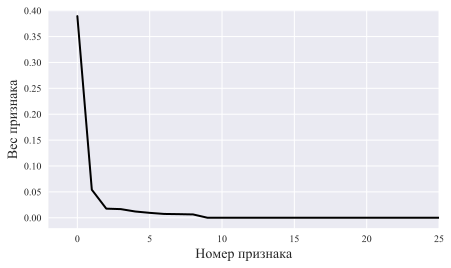

In [20]:
plt.figure(figsize=(7,4))
s = np.copy(w)
s = -np.sort(-s)
plt.axis('tight')
plt.plot(s,linewidth = 2, c = 'black')
plt.ylabel('Вес признака', FontSize =  14)
plt.xlabel('Номер признака', FontSize =  14)
plt.axis([-2, 25, -0.02, 0.4])
plt.savefig('QP1.eps')
#plt.title('График значимости признаков')

#plt.plot(data[:12 * 365 * 3], linewidth = 0.4, c = 'black')
#plt.axis('tight')
##plt.ylabel('Амплитуда сигнала', FontSize =  14)
#plt.xlabel('Отсчеты времени, $t$', fontsize = 14)

# результаты QP

In [16]:
print("k   AIC      BIC      Cp         r        v       Sa(k)      SMAPE(k)")
for k in range(2,20):
    print(k, " %7.2f, %7.2f, %7.2f, %7.2f, %7.5f, %7.2f  %7.3f" % all(k,n,w))

k   AIC      BIC      Cp         r        v       Sa(k)      SMAPE(k)
2  25936.67, 25947.88, -1992.83,   -5.62, 0.09176, 855536422.07    0.038
3  26138.70, 26155.51, -1990.49,   -7.12, 1.43546, 945527810.85    0.041
4  26465.73, 26488.13, -1987.87,   -8.12, 4.83177, 1112379370.29    0.045
5  26586.58, 26614.58, -1985.62,  -10.07, 1.75236, 1180485000.51    0.047
6  26467.57, 26501.18, -1983.88,  -10.36, 3.63021, 1111180735.53    0.045
7  26581.25, 26620.46, -1981.64,  -10.50, 2.95349, 1174993961.69    0.046
8  26926.21, 26971.02, -1978.83,  -10.60, 1.80006, 1394785753.38    0.051
9  26931.75, 26982.15, -1976.82,  -10.69, 3.03053, 1397255596.53    0.051
10  26839.80, 26895.81, -1975.05,  -10.90, 4.94060, 1333141427.91    0.050
11  26841.80, 26903.41, -1973.05,  -10.90, 4.94060, 1333141427.91    0.050


/Users/Vasiliy/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/Vasiliy/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


12  26647.45, 26714.66, -1971.52,    -inf, 36.60728, 1208477997.82    0.047
13  26649.45, 26722.26, -1969.52,    -inf, 36.60728, 1208477997.82    0.047
14  26651.45, 26729.86, -1967.52,    -inf, 36.60728, 1208477997.82    0.047
15  26653.45, 26737.46, -1965.52,    -inf, 36.60728, 1208477997.82    0.047
16  26655.45, 26745.06, -1963.52,    -inf, 36.60728, 1208477997.82    0.047
17  26657.45, 26752.67, -1961.52,    -inf, 36.60728, 1208477997.82    0.047
18  26659.45, 26760.27, -1959.52,    -inf, 36.60728, 1208477997.82    0.047
19  26661.45, 26767.87, -1957.52,    -inf, 36.60728, 1208477997.82    0.047
